In [1]:
# Datamanipulation and math packages
import numpy as np 
import pandas as pd
import re
import collections
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.linear_model import LogisticRegression, RidgeClassifier

# text preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk 
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

#data modeling
from keras import layers
from keras import models
from keras import regularizers
from keras.models import Sequential

# Data Viz
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# disable warnings and def print yellow()
pd.options.mode.chained_assignment = None
def prYellow(skk): print("\033[93m {}\033[00m" .format(skk))


Using TensorFlow backend.


In [2]:
# Global Vars
NUM_WORDS = 17500
NB_START_EPOCHS = 40  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  

### here are some data processing functions

In [7]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='Adam'
                  , loss='binary_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=False)
    return history

def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

def remove_stopwords(input_text):
    '''
    uses NLTK Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

def remove_links(input_text):
    '''
    Function to remove hyperlinks, preceded by an HTTPS in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', input_text, flags=re.MULTILINE)

def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [8]:
## In this section we import the tweet files, clean the training data, 
## and split it for training and validation
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index))
training_df_clean = train_df[['text','target']]
training_df_clean['text'] = training_df_clean['text'].apply(remove_stopwords).apply(remove_mentions).apply(remove_links)
#split in to train and validate sets
x_train, x_test, y_train, y_test = model_selection.train_test_split\
(training_df_clean['text'],training_df_clean['target'],test_size=0.1)

####
# Now lets clean and prep the test set
####
testing_df_clean = test_df
testing_df_clean['text'] =  testing_df_clean['text'].apply(remove_stopwords).apply(remove_mentions).apply(remove_links)

In [ ]:
print(f'{x_train}')

## <font color=red>Keras</font> Tokenizer 

In [9]:
tk = Tokenizer(num_words=NUM_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(x_train)

In [11]:
x_train_oh = tk.texts_to_matrix(x_train, mode='binary')
x_test_oh = tk.texts_to_matrix(x_test, mode='binary')

In [12]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [13]:
y_train_oh

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### END tokenizing + fitting and transforming

### BEGIN model baseline definitions

##  <font color=green>Our Baseline Logistic Regression and Ridge model tests show 80% accuracy and 78% accuracy for our 2 tests</font>

## <font color=red>We now begin the Deep Neural Network (KERAS) implementation

In [14]:
base_model = models.Sequential()
base_model.add(layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)))
base_model.add(layers.Dense(16, activation='relu'))
base_model.add(layers.Dense(2, activation='sigmoid'))
base_model.name = 're model'

#### Compiling the model happens in deep_model() helper function

Minimum validation loss reached in epoch 9


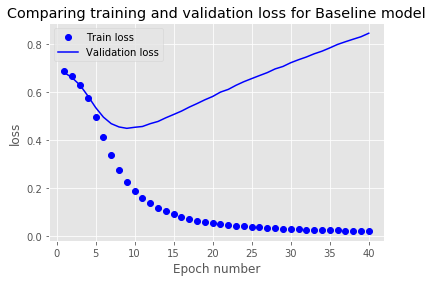

In [15]:
base_history = deep_model(base_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

### <font color=cyan>This model clearly starts overfitting around epoch 3

##### <font color=red> \*\*Note that if you rerun the .fit() method, you’ll start off with the computed weights from the previous training. Make sure to compile the model again before you start training the model again.\*\*</font> We do this in deep_model(), at the top
    

### <font color=green>evaluate the accuracy model:

In [16]:
loss, accuracy = base_model.evaluate(x_train_oh, y_train_oh, verbose=False)
prYellow('Training Accuracy: {:.4f}'.format(accuracy))
val_loss, val_accuracy = base_model.evaluate(x_test_oh, y_test_oh, verbose=False)
prYellow('Validation Set Accuracy:  {:.4f}'.format(val_accuracy))

 Training Accuracy: 0.9916
 Validation Set Accuracy:  0.7559


## Now we begin creating model revisions
<font color=green> First lets reduce the neural network's capacity by removing a hidden layeer and reducting nodes

Minimum validation loss reached in epoch 21


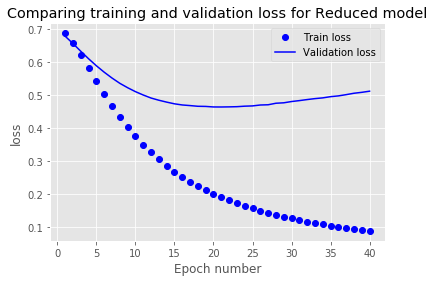

In [17]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)))
reduced_model.add(layers.Dense(2, activation='sigmoid'))
reduced_model.name = 'Reduced model'

reduced_history = deep_model(reduced_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

In [18]:
loss, accuracy = reduced_model.evaluate(x_train_oh, y_train_oh, verbose=False)
prYellow('Training Accuracy: {:.4f}'.format(accuracy))
val_loss, val_accuracy = reduced_model.evaluate(x_test_oh, y_test_oh, verbose=False)
prYellow('Validation Set Accuracy:  {:.4f}'.format(val_accuracy))

 Training Accuracy: 0.9801
 Validation Set Accuracy:  0.7835


### <font color=blue> Next lets apply regularization

Minimum validation loss reached in epoch 4


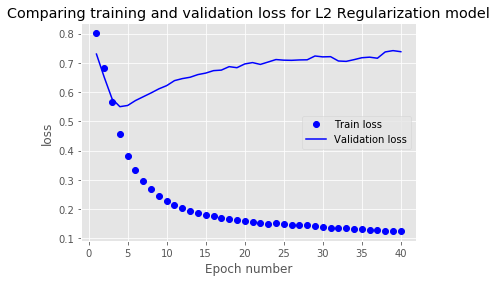

In [19]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NUM_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(2, activation='sigmoid'))
reg_model.name = 'L2 Regularization model'
reg_history = deep_model(reg_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh)
reg_min = optimal_epoch(reg_history)
#graph
eval_metric(reg_model, reg_history, 'loss')

In [20]:
loss, accuracy = reg_model.evaluate(x_train_oh, y_train_oh, verbose=False)
prYellow('Training Accuracy: {:.4f}'.format(accuracy))
val_loss, val_accuracy = reg_model.evaluate(x_test_oh, y_test_oh, verbose=False)
prYellow('Validation Set Accuracy:  {:.4f}'.format(val_accuracy))

 Training Accuracy: 0.9908
 Validation Set Accuracy:  0.7743


### <font color=indianred> Now let's add dropout layers</font> A dropout layer will randomly set output features of a layer to zero.

Minimum validation loss reached in epoch 5


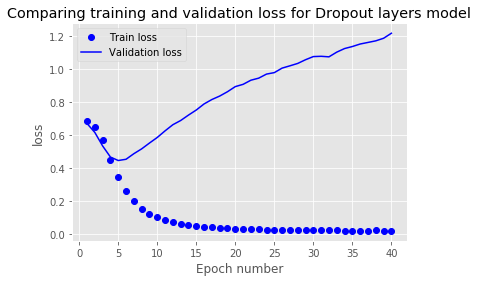

In [21]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NUM_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(2, activation='sigmoid'))
drop_model.name = 'Dropout layers model'
drop_history = deep_model(drop_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

In [22]:
loss, accuracy = reg_model.evaluate(x_train_oh, y_train_oh, verbose=False)
prYellow('Training Accuracy: {:.4f}'.format(accuracy))
val_loss, val_accuracy = reg_model.evaluate(x_test_oh, y_test_oh, verbose=False)
prYellow('Validation Set Accuracy:  {:.4f}'.format(val_accuracy))

 Training Accuracy: 0.9908
 Validation Set Accuracy:  0.7743


## Composite model

Minimum validation loss reached in epoch 31


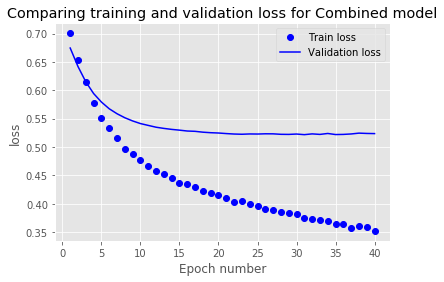

In [23]:
combined_model = models.Sequential()
combined_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NUM_WORDS,)))
combined_model.add(layers.Dropout(0.5))
combined_model.add(layers.Dense(2, activation='sigmoid'))
combined_model.name = 'Combined model'

combined_history = deep_model(combined_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh)
combined_min = optimal_epoch(combined_history)
eval_metric(combined_model, combined_history, 'loss')

## Test results

In [24]:
base_results = test_model(base_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, drop_min)
combined_model = test_model(combined_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, combined_min)

762/762 [==============================] - 0s 53us/step

Test accuracy: 75.39%
762/762 [==============================] - 0s 47us/step

Test accuracy: 77.62%
762/762 [==============================] - 0s 91us/step

Test accuracy: 77.23%
762/762 [==============================] - 0s 75us/step

Test accuracy: 76.18%
762/762 [==============================] - 0s 85us/step

Test accuracy: 80.12%
